# CS 5665 - Introduction to Data Science

## Preprocessing

The data used in this project is from [this](https://www.kaggle.com/c/linking-writing-processes-to-writing-quality). 

### Introducing the dataset and packages

In [2]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Import dataset
train_df = pd.read_csv('../data/train_logs.csv')
train_scores = pd.read_csv('../data/train_scores.csv')
test_logs = pd.read_csv('../data/test_logs.csv')

In [4]:
train_df.head(10)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
5,001519c8,6,107296,107400,104,Input,q,q,q,3,1
6,001519c8,7,107469,107596,127,Input,q,q,q,4,1
7,001519c8,8,107659,107766,107,Input,q,q,q,5,1
8,001519c8,9,107743,107852,109,Input,q,q,q,6,1
9,001519c8,10,107840,107978,138,Input,Space,Space,,7,1


### Cleaning Data and Feature Engineering
Before we can split, we need to convert the keystroke measurements to the appropriate metrics for each user. Due to these metric types originally being event dependent, we will be dropping 'cursor_position', 'down_event', 'up_event', and 'text_change.' 

In [5]:
cleaned_data = train_df.drop(columns=['cursor_position','down_event', 'up_event','text_change']).groupby('id').sum() 
mins_data = train_df.drop(columns=['cursor_position','down_event', 'up_event','text_change']).groupby("id").min()
maxes_data = train_df.drop(columns=['cursor_position','down_event', 'up_event','text_change']).groupby("id").max()

cleaned_data['min_down_time'] = mins_data['down_time']
cleaned_data['max_up_time'] = maxes_data['up_time']
cleaned_data['min_action_time'] = mins_data['action_time']
cleaned_data['max_action_time'] = maxes_data['action_time']
cleaned_data = cleaned_data.merge(train_scores, on='id')


cleaned_test = test_logs.drop(columns=['cursor_position','down_event', 'up_event','text_change']).groupby('id').sum()
mins_test = test_logs.drop(columns=['cursor_position','down_event', 'up_event','text_change']).groupby("id").min() 
maxes_test = test_logs.drop(columns=['cursor_position','down_event', 'up_event','text_change']).groupby("id").max()

cleaned_test['min_down_time'] = mins_test['down_time']
cleaned_test['max_up_time'] = maxes_test['up_time']
cleaned_test['min_action_time'] = mins_test['action_time']
cleaned_test['max_action_time'] = maxes_test['action_time']
cleaned_test = cleaned_test.merge(train_scores, on='id')

cleaned_data.describe()

C:\Users\Nate\AppData\Local\Temp\ipykernel_4464\2584426937.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cleaned_data = train_df.drop(columns=['cursor_position','down_event', 'up_event','text_change']).groupby('id').sum()
C:\Users\Nate\AppData\Local\Temp\ipykernel_4464\2584426937.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cleaned_test = test_logs.drop(columns=['cursor_position','down_event', 'up_event','text_change']).groupby('id').sum()


,event_id,down_time,up_time,action_time,word_count,min_down_time,max_up_time,min_action_time,max_action_time,score
count,2.471000e+03,2.471000e+03,2.471000e+03,2.471000e+03,2.471000e+03,2.471000e+03,2.471000e+03,2471.000000,2471.000000,2471.000000
mean,7.033772e+06,2.699550e+09,2.699883e+09,3.336675e+05,7.874151e+05,4.239387e+04,1.769537e+06,0.116957,2989.163497,3.711251
std,7.095160e+06,1.727236e+09,1.727350e+09,1.575202e+05,7.298654e+05,1.658284e+05,2.760283e+05,1.289195,13084.145614,1.024937
min,3.445300e+04,1.723896e+07,1.725651e+07,1.345200e+04,5.044000e+03,1.060000e+02,2.295480e+05,0.000000,153.000000,0.500000
25%,2.406818e+06,1.552195e+09,1.552490e+09,2.111480e+05,2.945275e+05,2.131500e+03,1.754901e+06,0.000000,515.000000,3.000000
50%,4.750903e+06,2.315883e+09,2.316161e+09,3.049510e+05,5.629010e+05,2.114900e+04,1.792315e+06,0.000000,1278.000000,4.000000
75%,9.251451e+06,3.441110e+09,3.441537e+09,4.248140e+05,1.018560e+06,4.592500e+04,1.807774e+06,0.000000,2648.500000,4.500000
max,8.290213e+07,2.424430e+10,2.424494e+10,1.210508e+06,6.546254e+06,7.452424e+06,8.313707e+06,32.000000,447470.000000,6.000000


In order to make the model as simple and linear as possible, each essay's event IDs, down/up times, action times, word counts, and scores have been made into one table by combining the metrics by essay ID (some by max, min, or sum, which is functionally the same as mean in these cases). This will result in massive losses in precision capability but should still produce reasonably good results while being massively faster to work with.

### Preprocessing



In [6]:
# Identify numeric feature statistics
cleaned_data.info()
cleaned_data.describe(include='all')

# Checking for missing values
cleaned_data.describe(include="all").loc['count']
cleaned_data["action_time"].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2470
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2471 non-null   object 
 1   event_id         2471 non-null   int64  
 2   down_time        2471 non-null   int64  
 3   up_time          2471 non-null   int64  
 4   action_time      2471 non-null   int64  
 5   word_count       2471 non-null   int64  
 6   min_down_time    2471 non-null   int64  
 7   max_up_time      2471 non-null   int64  
 8   min_action_time  2471 non-null   int64  
 9   max_action_time  2471 non-null   int64  
 10  score            2471 non-null   float64
dtypes: float64(1), int64(9), object(1)
memory usage: 231.7+ KB


count    2.471000e+03
mean     3.336675e+05
std      1.575202e+05
min      1.345200e+04
25%      2.111480e+05
50%      3.049510e+05
75%      4.248140e+05
max      1.210508e+06
Name: action_time, dtype: float64

In [7]:
drop_variables = ['id']
passthrough_variables = ['score']
scale_variables = ['event_id', 'down_time', 'up_time', 'action_time', 'word_count',
                   'min_down_time', 'max_up_time', 'min_action_time', 'max_action_time']

In [8]:
preprocessor = make_column_transformer(
    ('drop', drop_variables),
    ("passthrough", passthrough_variables),
    (StandardScaler(), scale_variables)
)

In [9]:
transformed = preprocessor.fit_transform(cleaned_data)
column_names = passthrough_variables + scale_variables

In [10]:
X_trained_transformed = pd.DataFrame(transformed, columns=column_names)
X_trained_transformed

,score,event_id,down_time,up_time,action_time,word_count,min_down_time,max_up_time,min_action_time,max_action_time
0,3.5,-0.530521,-0.307346,-0.307347,-0.231284,-0.630137,-0.228402,0.117518,-0.090739,-0.055817
1,3.5,-0.566908,-0.825925,-0.825904,-0.370037,-0.464609,-0.070997,0.070412,-0.090739,-0.094115
2,6.0,0.214492,0.421043,0.421065,0.555810,0.024893,-0.228915,0.007724,-0.090739,0.001211
3,2.0,-0.820785,-0.855492,-0.855519,-0.914808,-0.858118,-0.006025,-1.322843,-0.090739,-0.166889
4,4.0,-0.539847,-0.517724,-0.517701,-0.126774,-0.645222,0.217595,-0.387956,-0.090739,-0.174916
...,...,...,...,...,...,...,...,...,...,...
2466,3.5,0.591743,0.456797,0.456863,1.054063,0.585768,-0.120190,0.080123,-0.090739,0.025520
2467,4.0,-0.513420,-0.293632,-0.293682,-0.758447,-0.283245,-0.124623,0.107390,-0.090739,-0.141051
2468,1.5,-0.330046,0.616673,0.616573,-0.648223,-0.417585,-0.114068,0.687843,-0.090739,-0.185389
2469,5.0,-0.250485,-0.480910,-0.480904,-0.280837,-0.164217,-0.135763,-0.945867,-0.090739,-0.122399


### Splitting Data

In [11]:
# for run time consistency, set seed
np.random.seed(42)
train_df, test_df = train_test_split(X_trained_transformed, test_size=0.2, random_state=42)
y_train = train_df['score']
X_train = train_df.drop(columns='score')
y_test = test_df['score']
X_test = test_df.drop(columns='score')



### Dummy Submission

In [12]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_df.drop(columns=['score']), train_df['score'])

DummyClassifier(strategy='most_frequent')

In [13]:
# Predict
prediction = pd.DataFrame()
prediction['id'] = cleaned_test.index
prediction ['score']= dummy_clf.predict(cleaned_test)
print(prediction.info())

prediction.to_csv('../data/prediction.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      0 non-null      object 
 1   score   0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 0.0+ bytes
None


## Dummy Submission Checkpoint 2 (1)

In [14]:
dummy_clf_2_1 = DummyClassifier(strategy="uniform")
dummy_clf_2_1.fit(train_df.drop(columns=['score']), train_df['score'])

DummyClassifier(strategy='uniform')

In [15]:
# Predict
prediction = pd.DataFrame()
prediction['id'] = cleaned_test.index
prediction ['score']= dummy_clf.predict(cleaned_test)

prediction.to_csv('../data/prediction_2_1.csv', index=False)

prediction

,id,score


## Dummy Submission Checkpoint 2 (2)

In [16]:
dummy_clf_2_2 = DummyClassifier(strategy="prior")
dummy_clf_2_2.fit(train_df.drop(columns=['score']), train_df['score'])

DummyClassifier()

In [17]:
# Predict
prediction = pd.DataFrame()
prediction['id'] = cleaned_test.index
prediction['score'] = dummy_clf.predict(cleaned_test)

prediction.to_csv('../data/prediction_2_2.csv', index=False)

prediction

,id,score


# Model Selection
We will compare the efficiency of each of the following regression models:
- Ordinary Least Squares
- Ridge Regression
- Support Vector
- Decision Tree
- Random Forest

In [18]:
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
import xgboost as x
models = {
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    DecisionTreeRegressor(max_depth=15),
    RandomForestRegressor(n_estimators=50, max_depth=7, random_state=42),
    svm.SVR(),
    KNeighborsRegressor(n_neighbors=13),
    AdaBoostRegressor(random_state=42),
    GradientBoostingRegressor(),
    x.XGBRegressor()
}


In [19]:
print("MSE:")
for model in models:
    model.fit(X_train, y_train)
    print(type(model).__name__, 1 - model.score(X_test, y_test))

MSE:
SVR 0.482053007288904


RandomForestRegressor 0.4543232772860202
AdaBoostRegressor 0.5173005645207474
XGBRegressor 0.5612403917046411
KNeighborsRegressor 0.526243120665214
LinearRegression 0.5984132917496133
Ridge 0.5983881484888586
GradientBoostingRegressor 0.47421239353922895
DecisionTreeRegressor 1.006173312933945


Random Forest parameter search:

In [20]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [22]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV


params = {
    "max_depth": randint(5, 8),
    "n_estimators": randint(60, 80)
}

search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=params, random_state=42, n_iter=100, cv=3, verbose=1, n_jobs=1, return_train_score=True)

#search.fit(X_train, y_train)

#report_best_scores(search.cv_results_, 3)

In [23]:
forests = [
        
        RandomForestRegressor(n_estimators=70, max_depth=7, random_state=42), #Best RFR found from manual search
        RandomForestRegressor(n_estimators=66, max_depth=5, random_state=42),
        RandomForestRegressor(n_estimators=63, max_depth=5, random_state=42),
        RandomForestRegressor(n_estimators=66, max_depth=6, random_state=42),
        RandomForestRegressor(n_estimators=63, max_depth=6, random_state=42),
]

In [24]:
print("MSE, lower is better")
for i in range(len(forests)):
    f = forests[i]
    f.fit(X_train, y_train)
    print(i, 1 - f.score(X_test, y_test))

MSE, lower is better
0 0.4537383120839711
1 0.45296560016317233
2 0.4532628790619486
3 0.45344189551594816
4 0.4531786420286814


A MSE of .453 when the scale is from 0 to 6 is not too bad considering how few features have been used, and especially since it was reduced from time-series to per-essay. So the best tree-based model we have found is a random forest with a maximum depth of 5 and 66 estimators, based on validation set scores. Let's check the predictions themselves to see what's happening:

In [25]:
best_forest = RandomForestRegressor(n_estimators=66, max_depth=5, random_state=42)
best_forest.fit(X_train, y_train)
forest_preds = best_forest.predict(X_test)
print(best_forest.score(X_test, y_test))

0.5470343998368277


<function matplotlib.pyplot.show(close=None, block=None)>

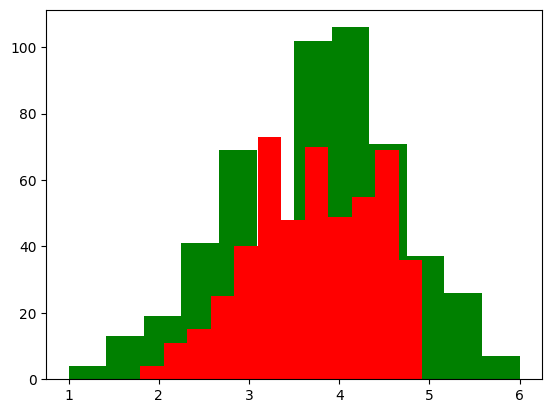

In [26]:
plt.hist(y_test, color='green', bins=12)
plt.hist(forest_preds, color='red', bins=12)
plt.show

The distribution is not bad, but too narrow and seems to be confused about scores between 3 and 4. Let's see how a ridumentary nerual net performs.

# Neural Network Attempts

In [51]:
import os
import shutil
import time
import torch
import torch.nn as nn
import torch.optim as optim
torch.use_deterministic_algorithms(True)

X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [77]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x
    
input_size = X_train_t.shape[1]
hidden_size = 30
output_size = 1
learning_rate = 0.1
num_epochs =100

model = Net(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [78]:

torch.manual_seed(0)
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    predicted = model(X_test_t)
    test_loss = criterion(predicted, y_test_t)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 1.0126
Epoch [20/100], Loss: 0.7239
Epoch [30/100], Loss: 0.6674
Epoch [40/100], Loss: 0.6401
Epoch [50/100], Loss: 0.6227
Epoch [60/100], Loss: 0.6151
Epoch [70/100], Loss: 0.8202
Epoch [80/100], Loss: 0.6538
Epoch [90/100], Loss: 0.5959
Epoch [100/100], Loss: 0.5858
Test Loss: 0.4744


This isn't bad at all considering it is similar to how a random forest performs. Let's see how adding another layer impacts performance.

In [30]:
class Net2(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        return x
    
input_size = X_train_t.shape[1]
hidden_size = 30
hidden_size_2 = 30
output_size = 1
learning_rate = 0.01
num_epochs = 1000

model2 = Net2(input_size, hidden_size, hidden_size_2, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [31]:
for epoch in range(num_epochs):
    model2.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model2.eval()
with torch.no_grad():
    predicted = model2(X_test_t)
    test_loss = criterion(predicted, y_test_t)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/1000], Loss: 0.5894
Epoch [20/1000], Loss: 0.5889
Epoch [30/1000], Loss: 0.5885
Epoch [40/1000], Loss: 0.5880
Epoch [50/1000], Loss: 0.5875
Epoch [60/1000], Loss: 0.5871
Epoch [70/1000], Loss: 0.5866
Epoch [80/1000], Loss: 0.5862
Epoch [90/1000], Loss: 0.5858
Epoch [100/1000], Loss: 0.5854
Epoch [110/1000], Loss: 0.5849
Epoch [120/1000], Loss: 0.5845
Epoch [130/1000], Loss: 0.5841
Epoch [140/1000], Loss: 0.5837
Epoch [150/1000], Loss: 0.5833
Epoch [160/1000], Loss: 0.5829
Epoch [170/1000], Loss: 0.5825
Epoch [180/1000], Loss: 0.5821
Epoch [190/1000], Loss: 0.5818
Epoch [200/1000], Loss: 0.5814
Epoch [210/1000], Loss: 0.5810
Epoch [220/1000], Loss: 0.5806
Epoch [230/1000], Loss: 0.5803
Epoch [240/1000], Loss: 0.5799
Epoch [250/1000], Loss: 0.5796
Epoch [260/1000], Loss: 0.5792
Epoch [270/1000], Loss: 0.5789
Epoch [280/1000], Loss: 0.5785
Epoch [290/1000], Loss: 0.5782
Epoch [300/1000], Loss: 0.5778
Epoch [310/1000], Loss: 0.5775
Epoch [320/1000], Loss: 0.5772
Epoch [330/1000],